In [241]:
import tensorflow as tf
import os

In [242]:
cpus = tf.config.experimental.list_physical_devices('CPU')
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [243]:
cpus = tf.config.experimental.list_physical_devices('GPU')
for cpu in cpus:
    tf.config.experimental.set_memory_growth(cpu, True)

In [244]:
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np

In [245]:
data_dir = 'dataset'

In [246]:
os.listdir(os.path.join(data_dir, 'intersecting'))

['intersecting2.png',
 'Screenshot 2024-06-11 130058.png',
 'Screenshot 2024-06-11 130058_cleanup.png',
 'Screenshot 2024-06-11 130208.png',
 'Screenshot 2024-06-11 130208_cleanup.png',
 'Screenshot 2024-06-11 130337.png',
 'Screenshot 2024-06-11 130429.png',
 'WhatsApp Image 2024-05-10 at 16.10.31.jpeg']

In [247]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [248]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [249]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### Load Data

In [250]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [251]:
# --- 1. Define 'data' ---
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',  # Infers labels from directory structure
    label_mode='categorical',  # One-hot encoded labels
    image_size=(256, 256),  # Adjust if your images have different dimensions
    batch_size=8,  # Adjust based on your memory constraints
)

Found 53 files belonging to 4 classes.


In [252]:
data_iterator = data.as_numpy_iterator()

In [253]:
batch = data_iterator.next()

In [254]:
batch[0].shape

(8, 256, 256, 3)

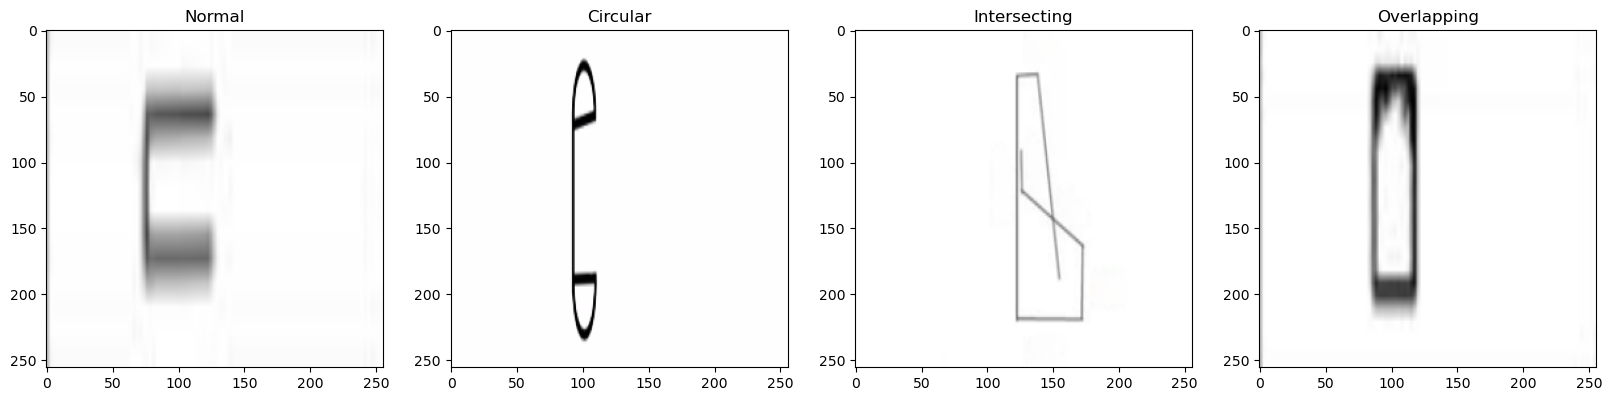

In [255]:
class_names = {
    0: "Circular",
    1: "Intersecting",
    2: "Normal",
    3: "Overlapping",
}


fig, ax = plt.subplots(ncols=4, figsize=(20, 25))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # Convert NumPy array to a hashable type (e.g., integer)
    label_index = np.argmax(batch[1][idx])  # Get index of the highest probability class
    ax[idx].title.set_text(class_names.get(label_index, "Unknown"))

    # Add x and y ticks (adjust values based on your image dimensions)
    ax[idx].set_xticks(np.arange(0, img.shape[1], 50))  # Ticks every 50 pixels on x-axis
    ax[idx].set_yticks(np.arange(0, img.shape[0], 50))  # Ticks every 50 pixels on y-axis

    # Optionally, label the ticks with pixel values
    ax[idx].set_xticklabels(np.arange(0, img.shape[1], 50))
    ax[idx].set_yticklabels(np.arange(0, img.shape[0], 50))

plt.show()

### Scale Data

In [256]:
data = data.map(lambda x,y: (x/255, y))
# important since it helps to perform transformation to convert image min to 0 and max to 1
# important while working with data pipeline

In [257]:
data.as_numpy_iterator().next()

(array([[[[0.7137255 , 0.7137255 , 0.7137255 ],
          [0.7467142 , 0.7467142 , 0.7467142 ],
          [0.86413145, 0.86413145, 0.86413145],
          ...,
          [0.9962776 , 0.9962776 , 0.9962776 ],
          [0.99306065, 0.99306065, 0.99306065],
          [0.99215686, 0.99215686, 0.99215686]],
 
         [[0.7137255 , 0.7137255 , 0.7137255 ],
          [0.7467142 , 0.7467142 , 0.7467142 ],
          [0.86413145, 0.86413145, 0.86413145],
          ...,
          [0.9962776 , 0.9962776 , 0.9962776 ],
          [0.99306065, 0.99306065, 0.99306065],
          [0.99215686, 0.99215686, 0.99215686]],
 
         [[0.7137255 , 0.7137255 , 0.7137255 ],
          [0.7467142 , 0.7467142 , 0.7467142 ],
          [0.86413145, 0.86413145, 0.86413145],
          ...,
          [0.9962776 , 0.9962776 , 0.9962776 ],
          [0.99306065, 0.99306065, 0.99306065],
          [0.99215686, 0.99215686, 0.99215686]],
 
         ...,
 
         [[0.7137255 , 0.7137255 , 0.7137255 ],
          [0.74671

### Split Data

In [258]:
len(data) # num of batches

7

In [296]:
train_size = int(len(data)*.7)-1
val_size = int(len(data)*.2)+2
test_size = int(len(data)*.1)+1

In [297]:
train_size

3

In [298]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Established train, test and val partition

In [299]:
train_labels = np.concatenate([y for x, y in train], axis=0)
val_labels = np.concatenate([y for x, y in val], axis=0)
test_labels = np.concatenate([y for x, y in test], axis=0)

# One-hot encode the labels (if needed for your model)
train_labels = tf.keras.utils.to_categorical(train_labels)
val_labels = tf.keras.utils.to_categorical(val_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

### Building the model

In [300]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [301]:
num_classes = 4
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [302]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [303]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [304]:
logdir = 'logs'

In [305]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [306]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step - accuracy: 0.1823 - loss: 1.9523 - val_accuracy: 0.3333 - val_loss: 1.4030
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.2344 - loss: 1.3995 - val_accuracy: 0.2917 - val_loss: 1.3045
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.4271 - loss: 1.1196 - val_accuracy: 0.6667 - val_loss: 0.9480
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.5625 - loss: 1.2616 - val_accuracy: 0.7500 - val_loss: 1.2222
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.7552 - loss: 0.9715 - val_accuracy: 0.6667 - val_loss: 1.0997
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.6510 - loss: 0.9927 - val_accuracy: 0.8333 - val_loss: 0.7619
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.7083 - loss: 0.7706 - val_accuracy: 0.8750 - val_loss: 0.3411
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.7812 - loss: 0.7486 - val_accuracy: 0.7917 - val_loss:

In [307]:
hist.history

{'accuracy': [0.2083333283662796,
  0.25,
  0.4166666567325592,
  0.5,
  0.6666666865348816,
  0.7083333134651184,
  0.6666666865348816,
  0.75,
  0.7083333134651184,
  0.75,
  0.875,
  1.0,
  0.9583333134651184,
  0.9166666865348816,
  0.9166666865348816,
  0.9166666865348816,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [2.03226637840271,
  1.35968816280365,
  1.1195017099380493,
  1.284528374671936,
  1.0873180627822876,
  1.02902352809906,
  0.7637112736701965,
  0.8796212077140808,
  0.5740360617637634,
  0.688976526260376,
  0.46046969294548035,
  0.14113132655620575,
  0.1967957764863968,
  0.32870328426361084,
  0.15269289910793304,
  0.1855260729789734,
  0.033502835780382156,
  0.03847416117787361,
  0.008192985318601131,
  0.009224948473274708],
 'val_accuracy': [0.3333333432674408,
  0.2916666567325592,
  0.6666666865348816,
  0.75,
  0.6666666865348816,
  0.8333333134651184,
  0.875,
  0.7916666865348816,
  0.75,
  0.9583333134651184,
  0.875,
  0.9166666865348816,
  0.875,
  0.9

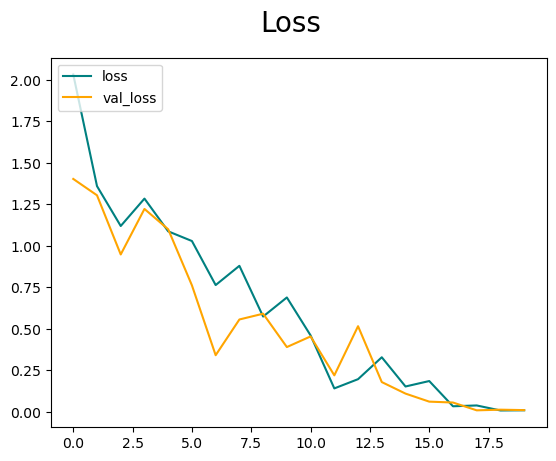

In [308]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

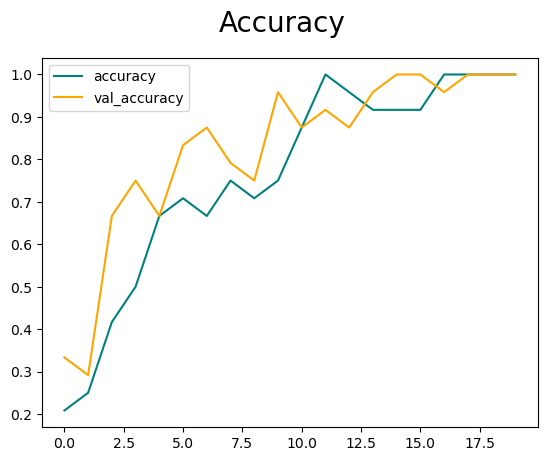

In [309]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluation

In [310]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [311]:
# Establishing instances
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [312]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step


In [313]:
print(f'Precision:{pre.result()}, Recall:{re.result().numpy()}, Acuraccy:{acc.result().numpy}')

Precision:1.0, Recall:1.0, Acuraccy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>


### Testing

In [314]:
import cv2

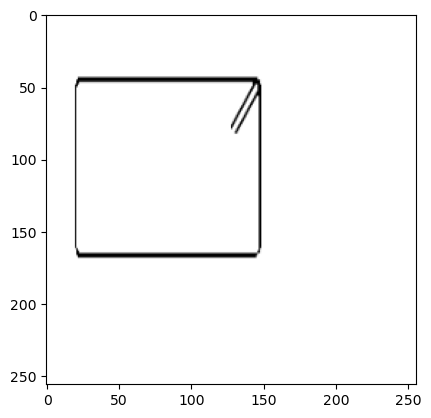

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Image belong to the Overlapping class


In [321]:
# Load and preprocess the image
img = cv2.imread('eval3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Predict the class
predict = model.predict(np.expand_dims(resize/255, 0))

class_names = ['Circular', 'Intersecting', 'Normal', 'Overlapping']
predicted_class = np.argmax(predict)

print(f'Image belong to the {class_names[predicted_class]} class')

### Saving the model

In [322]:
from tensorflow.keras.models import load_model

In [323]:
model.save('imageclassifier_4.keras')

In [324]:
prediction = tf.keras.models.load_model('imageclassifier_4.keras')

In [325]:
prediction

<Sequential name=sequential_6, built=True>

In [326]:
yhatnew = prediction.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


In [328]:
class_names = ['Circular', 'Intersecting', 'Normal', 'Overlapping']
predicted_class = np.argmax(predict)

print(f'Image belong to the {class_names[predicted_class]} class')

Image belong to the Overlapping class
